# Density-Based Spatial Clustering of Applications with Noise from Scratch
***
## Table of Contents
1. [Introduction](#1-introduction)
***

In [222]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.typing import NDArray
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from typing import List, Tuple, Dict

## 1. Introduction
Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a density-based clustering algorithm (unsupervised learning method) that groups data points in high-density regions while identifying outliers in low-density areas. Unlike centroid-based methods like K-Means, it discovers arbitrarily shaped clusters without requiring pre-specified cluster counts.

### Key Concepts
- $\epsilon$: Radius that defines the neighbourhood of each point.
- $\text{MinPts}$: Minimum number of points required in the $\epsilon$-neighbourhood to form a cluster.
- DBSCAN algorithm identifies the following three types of points during the process:
    - **Core point**: A point that has at least $\text{MinPts}$ neighbours (including itself) within $\epsilon$.
    - **Border point**: A point within $\epsilon$ of a core point but has less than  $\text{MinPts}$ neighbours.
    - **Noise point**: A point that is neither core nor border; considered as an outlier.

### Steps
1. Normalise features for equal scaling.
2. Identify core points.
3. Expand clusters from core points via density reachability while assigning border points (core -> border).
4. Label non-reachable points as noise points.

## 2. Loading Data

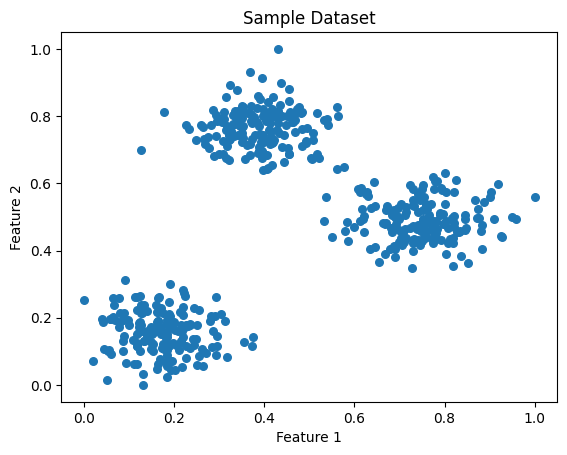

In [223]:
# Generate 500 samples, 3 cluster centers, 2 features (for 2D visualisation)
X, y = make_blobs(n_samples=500, centers=3, cluster_std=1.6,
                  #   c=y, cmap="viridis",
                  n_features=2, random_state=42)

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))

# Visualise the dataset
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=30)
plt.title("Sample Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [224]:
X.describe()

,0,1
count,500.000000,500.000000
mean,0.437284,0.470313
std,0.250494,0.255426
min,0.000000,0.000000
25%,0.217315,0.203571
50%,0.394213,0.484234
75%,0.693504,0.722237
max,1.000000,1.000000


## 3. Identifying Core Points
For each data point, we compute the Euclidean distance to count neighbours within the range $\epsilon$. Mark them as 'core' if the number of neighbours is $\geq \text{MinPts}$. Euclidean distance is calculated as:

\begin{align*}
\sqrt{\sum_{i=1}^{n} (a_i - b_i)^2}
\end{align*}

In [225]:

def find_neighbours(data: pd.DataFrame, point_idx: int, epsilon: float) -> List[int]:
    """Return indices of points within epsilon distance of data[point_idx]."""
    data_np = data.values  # Convert to np.array
    distances = np.linalg.norm(
        data_np - data_np[point_idx], axis=1)  # Vectorised
    # Get indices where distance <= epsilon
    neighbours = np.where(distances <= epsilon)[0].tolist()
    return neighbours

A sample point (X.iloc[100]) has 34 neighbours.


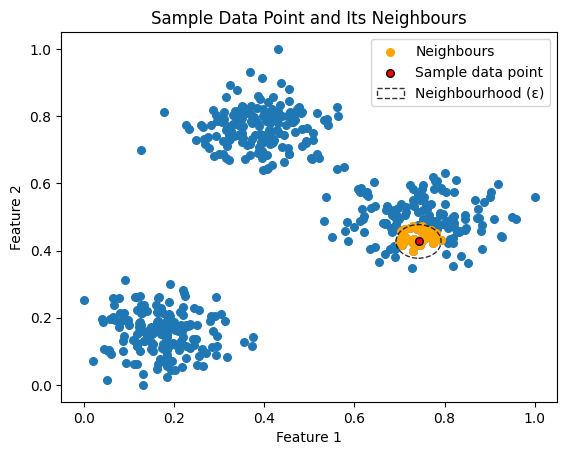

In [226]:
epsilon = 0.05
min_pts = 5
test_point_idx = 100
test_neighbours = find_neighbours(X, [test_point_idx], epsilon)
print(
    f'A sample point (X.iloc[{test_point_idx}]) has {len(test_neighbours)} neighbours.')
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=30)
plt.scatter(X.iloc[test_neighbours, 0],
            X.iloc[test_neighbours, 1], s=30, c='orange', label='Neighbours')
plt.scatter(X.iloc[test_point_idx, 0],
            X.iloc[test_point_idx, 1], s=30, c='red', edgecolor='black', label='Sample data point')

circle = plt.Circle(
    (X.iloc[test_point_idx, 0], X.iloc[test_point_idx, 1]),
    radius=epsilon,
    color='black',
    fill=False,
    linestyle='--',
    alpha=0.8,
    label='Neighbourhood (ε)'
)
plt.gca().add_patch(circle)
plt.title("Sample Data Point and Its Neighbours")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

## 4. Cluster Formation
We will expand clusters from core points using density reachability as follows:
1. Initialise cluster (starting point = `cluster_id`).
2. Iterate through the `neighbours` list.
3. Convert noise points to border points of the current cluster (noise should not have neighbours).
4. For unvisited points (`0`), assign to current cluster, check if it's a core point.
5. If core, dynamically extend the `neighbours` list with new points not already processed, enabling cluster expansion

In [227]:
def expand_cluster(data, labels, point_idx, neighbours, cluster_id, epsilon, min_pts):
    labels[point_idx] = cluster_id
    i = 0
    while i < len(neighbours):
        neighbor_idx = neighbours[i]
        if labels[neighbor_idx] == -1:  # Noise -> Border
            labels[neighbor_idx] = cluster_id
        elif labels[neighbor_idx] == 0:  # Unvisited
            labels[neighbor_idx] = cluster_id
            new_neighbours = find_neighbours(data, neighbor_idx, epsilon)
            if len(new_neighbours) >= min_pts:  # Core point
                neighbours += [n for n in new_neighbours if n not in neighbours]
        i += 1

## 5. Prediction
In the following prediction function, `labels` tracks point states:
- $0$: Unvisited
- $-1$: Noise
- $>0$: Cluster ID (e.g., 1, 2, ...)

The `labels` is initialised with all $0$ s.

In [228]:
def predict(data, epsilon, min_pts):
    n = len(data)
    labels = np.zeros(n)
    cluster_id = 0

    for i in tqdm(range(n)):
        if labels[i] != 0:
            continue

        neighbours = find_neighbours(data, i, epsilon)
        if len(neighbours) < min_pts:
            labels[i] = -1  # Mark as noise
        else:
            cluster_id += 1
            expand_cluster(data, labels, i, neighbours,
                           cluster_id, epsilon, min_pts)
    return labels


predicted_labels = predict(X, epsilon, min_pts)
X['cluster_label'] = predicted_labels.astype(int)

100%|██████████| 500/500 [00:00<00:00, 19709.70it/s]


In [229]:
X.head()

,0,1,cluster_label
0,0.261414,0.106147,1
1,0.532724,0.487513,-1
2,0.928071,0.441000,-1
3,0.357699,0.672051,2
4,0.848091,0.465689,3


## 6. Visualisation

In [230]:
# Plot clusters (labels >= 0)
def visualise_clusters(X: pd.DataFrame) -> None:
    for label in sorted(X['cluster_label'].unique()):
        if label == -1:
            # Noise points
            plt.scatter(
                X.loc[X['cluster_label'] == -1, X.columns[0]],
                X.loc[X['cluster_label'] == -1, X.columns[1]],
                s=30, c='black', label='Noise'
            )
        else:
            # Cluster points
            plt.scatter(
                X.loc[X['cluster_label'] == label, X.columns[0]],
                X.loc[X['cluster_label'] == label, X.columns[1]],
                s=30, label=f'Cluster {label}'
            )

    plt.title("Clusters with Noise")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

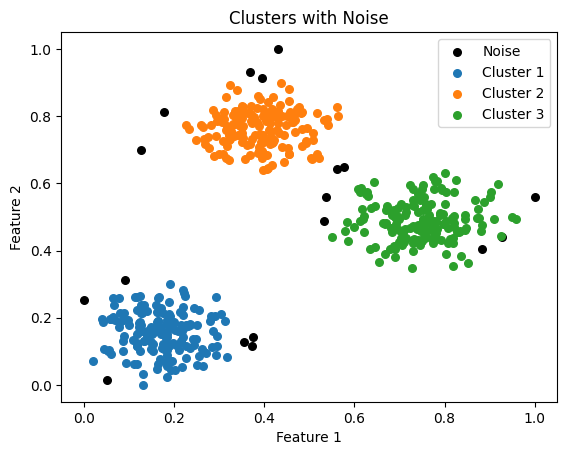

In [231]:
visualise_clusters(X)

## 7. Encapsulation

In [232]:
class CustomDBSCAN:
    def __init__(self, epsilon: float, min_pts: int) -> None:
        self.epsilon = epsilon
        self.min_pts = min_pts
        self.labels_ = None  # Cluster labels will be stored here after fitting

    def _find_neighbours(self, data: NDArray[np.float64], point_idx: int) -> List[int]:
        distances = np.linalg.norm(
            data - data[point_idx], axis=1)  # Vectorised
        # Get indices where distance <= epsilon
        return np.where(distances <= epsilon)[0].tolist()

    def _expand_cluster(self, data: NDArray[np.float64], labels: NDArray[np.int16],
                        point_idx: int, neighbours: List[int], cluster_id: int) -> None:
        labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbours):
            neighbour_idx = neighbours[i]

            if labels[neighbour_idx] == -1:  # Noise -> Border
                labels[neighbour_idx] = cluster_id
            elif labels[neighbour_idx] == 0:  # Unvisited
                labels[neighbour_idx] = cluster_id
                new_neighbours = self._find_neighbours(data, neighbour_idx)
                if len(new_neighbours) >= self.min_pts:  # Core point
                    neighbours += [n for n in new_neighbours if n not in neighbours]
            i += 1

    def fit(self, data: pd.DataFrame) -> List[int]:
        data_np = data.values
        n = len(data_np)
        labels = np.zeros(n, dtype=int)  # Initialise with all 0s.
        cluster_id = 0

        for i in tqdm(range(n), desc='Clustering'):
            if labels[i] != 0:  # Skip if already processed
                continue

            neighbours = self._find_neighbours(data_np, i)

            if len(neighbours) < self.min_pts:
                labels[i] = -1  # Mark as noise
            else:
                cluster_id += 1  # New cluster
                self._expand_cluster(data_np, labels, i,
                                     neighbours, cluster_id)
        self.labels_ = labels
        return labels

Clustering: 100%|██████████| 500/500 [00:00<00:00, 29229.41it/s]


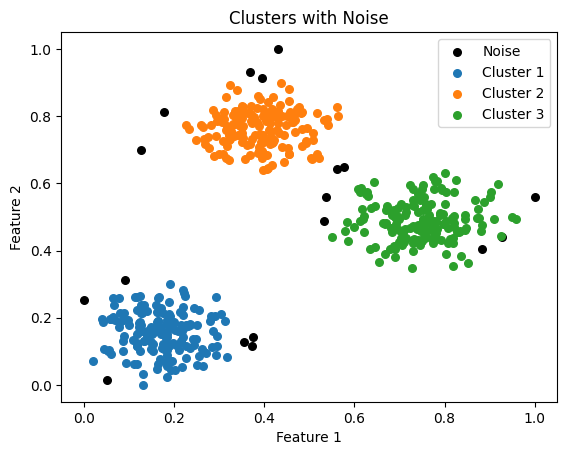

In [233]:
# Initialise with parameters
dbscan = CustomDBSCAN(epsilon=0.5, min_pts=5)

# Perform clustering
labels = dbscan.fit(X)

# Access results
X['cluster_label'] = labels  # Or dbscan.labels_
visualise_clusters(X)

## 8. Evaluation Metrics

### Silhouette Score
Silhouette score measures how well each data point fits within its cluster compared to other clusters. For each data point $i$, the silhouette values $s(i)$ quantifies two aspects:

- **Cohesion**: $a(i)$ - Cohesion is the average distance between $i$ and all other points in its cluster, indicating how close $i$ is to other points in the same cluster. Lower $a(i)$ means better cohesion.
- **Separation**: $b(i)$ - Separation is the minimum average distance between $i$ and points in any other cluster, demonstating how far $i$ is from points in the nearest different cluster. Higher $b(i)$ means better separation.

The silhouette score for point $i$ is then calculated as:
\begin{align*}
s(i) = \dfrac{b(i) - a(i)}{\text{max}(a(i), b(i))}
\end{align*}

The silouette score ranges from $-1$ to $+1$. Higer silhouette score indicates a better clustering result.
- Values close to $+1$ indicate that the point is well classified to its own cluster and poorly matched to neighbouring clusters (ideal).

- Values near $0$ indicate the point lies close to the boundary between two clusters.

- Values close to $-1$ suggest the point may be assigned to a wrong cluster (better fit elsewhere).

In [234]:
def silhouette_score(X: pd.DataFrame, labels: List[int]) -> np.float64:
    # Convert to NumPy array if DataFrame
    if not isinstance(X, np.ndarray):
        X = X.values

    unique_labels = np.unique(
        [label for label in labels if label != -1])  # without -1
    n_samples = len(X)
    silhouette_vals = np.zeros(n_samples)

    if len(unique_labels) < 2:
        return float('nan')  # Silhouette score undefined for < 2 clusters

    distance_matrix = np.linalg.norm(
        X[:, np.newaxis] - X[np.newaxis, :], axis=2)

    cluster_masks = {cluster: (labels == cluster) for cluster in unique_labels}

    for i in range(n_samples):
        if labels[i] == -1:
            silhouette_vals[i] = 0  # Noise points have 0 silhouette value
            continue

        own_cluster = labels[i]
        is_same_cluster = cluster_masks[own_cluster].copy()
        is_same_cluster[i] = False  # Excluding self

        # Calculate a_i
        if np.any(is_same_cluster):
            a_i = np.mean(distance_matrix[i, is_same_cluster])
        else:
            a_i = 0

        # Calculate b_i
        b_i = np.inf
        for cluster in unique_labels:
            if cluster == own_cluster:  # Skip own cluster
                continue
            other_mask = cluster_masks[cluster]
            if np.any(other_mask):
                distance = np.mean(distance_matrix[i, other_mask])
                if distance < b_i:
                    b_i = distance

        # Calculate silhouette for current point
        silhouette_vals[i] = (b_i - a_i) / \
            max(a_i, b_i) if max(a_i, b_i) > 0 else 0

    valid_points = labels != -1
    if not np.any(valid_points):
        return float('nan')
    return np.mean(silhouette_vals[valid_points]).round(4)

### Noise Ratio and Cluster Count
The following `noise_ratio_and_cluster_count` is used to evaluate two important aspects of DBSCAN clustering results:
- **Noise Ratio**:
    Noise ratio is the proportion of points in the dataset that DBSCAN has labelled as noise (outliers). A higher noise ratio indicate that the DBSCAN parameters ($\epsilon$ and $\text{MinPts}$) are too strict, or that the data is very noisy. The noise ratio is calculated as:
    
\begin{align*}
\text{Noise Ratio} = \dfrac{\text{Number of points with label:$-1$}}{\text{Total number of points}}
\end{align*}

- **Number of Clusters**:
    DBSCAN automatically determines the number of clusters based on the density of the data. It is computed as the number of unique labels excluding the noise label ($-1$).


In [235]:
def noise_ratio_and_cluster_count(labels: List[int]) -> Tuple[float, int]:
    labels = np.array(labels)
    is_noise = (labels == -1)
    noise_ratio = float(np.mean(is_noise))

    unique_labels = np.unique(
        [label for label in labels if label != -1])  # without -1
    n_clusters = len(unique_labels)
    return noise_ratio, n_clusters

In [236]:

def evaluate(X, labels) -> Dict[str, float | int]:
    silhouette = silhouette_score(X, labels)
    noise_ratio, n_clusters = noise_ratio_and_cluster_count(labels)
    return {
        'silhouette_score': silhouette,
        'noise_ratio': noise_ratio,
        'n_clusters': n_clusters
    }

In [ ]:
# After clustering
dbscan = CustomDBSCAN(epsilon=0.5, min_pts=5)
labels = dbscan.fit(X)

# Evaluate without ground truth
metrics = evaluate(X.values, labels)
print("Evaluation Metrics:")
print(f" - Silhouette: {metrics['silhouette_score']:.3f}")
print(f" - Noise Ratio: {metrics['noise_ratio']:.1%}")
print(f" - Clusters: {metrics['n_clusters']}")

Clustering: 100%|██████████| 500/500 [00:00<00:00, 31450.05it/s]

Evaluation Metrics:
 - Silhouette: 0.896
 - Noise Ratio: 3.6%
 - Clusters: 3
